<a href="https://cognitiveclass.ai"><img src = "https://ibm.box.com/shared/static/9gegpsmnsoo25ikkbl4qzlvlyjbgxs5x.png" width = 400> </a>

<h1 align=center><font size = 5>Segmenting and Clustering Neighborhoods along Hong Kong Tramsway (Art & Entertainment Venues) </font></h1>

## Introduction

In this lab, you will learn how to convert addresses into their equivalent latitude and longitude values. Also, you will use the Foursquare API to explore neighborhoods in along the Hong Kong Tramways. You will use the **explore** function to get the most common venue categories in each neighborhood, and then use this feature to group the neighborhoods into clusters. You will use the *k*-means clustering algorithm to complete this task. Finally, you will use the Folium library to visualize the neighborhoods their emerging clusters.

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Download and Explore Dataset</a>

2. <a href="#item2">Explore Neighborhoods in along Hong Kong Tramsways</a>

3. <a href="#item3">Analyze Each Neighborhood</a>

4. <a href="#item4">Cluster Neighborhoods</a>

5. <a href="#item5">Examine Clusters</a>    
</font>
</div>

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [1]:
!conda install -c conda-forge geopy --yes 

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.8.4

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.2 MB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-2.0.0

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values


import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


<a id='item1'></a>

## 1. Download and Explore Dataset

#### Tranform the data into a *pandas* dataframe

In [3]:
df = pd.read_excel (r'HK Tramsway.xlsx') 
df.head(10)

,Station No.,Station Name,Neighborhood,lat,long
0,KTT,Kennedy Town Terminus,Kennedy Town,22.283015,114.126
1,104W,Davis Street,Kennedy Town,22.283102,114.127
2,102W,Smithfield,Kennedy Town,22.283427,114.129
3,100W,Sands Street,Kennedy Town,22.283506,114.129
4,98W,Kennedy Town Praya,Kennedy Town,22.284337,114.13
5,96W,Queen' s Road West,Shek Tong Tsui,22.286228,114.132
6,94W,Whitty Street Depot,Shek Tong Tsui,22.287600,114.135
7,92W,Hill Road,Shek Tong Tsui,22.287143,114.134
8,WST,Shek Tong Tsui Terminus,Shek Tong Tsui,22.287158,114.135
9,90W,Whitty Street,Shek Tong Tsui,22.286814,114.136


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Station No.    68 non-null     object 
 1   Station Name   68 non-null     object 
 2   Neighborhood   68 non-null     object 
 3   lat            68 non-null     float64
 4   long           68 non-null     object 
dtypes: float64(1), object(4)
memory usage: 2.8+ KB


In [5]:
df.shape

(68, 5)

In [6]:
df['long']=df['long'].astype(float)

In [7]:
df.rename(columns={'Station Name ':'Station'}, inplace=True)

In [8]:
df.head()

,Station No.,Station,Neighborhood,lat,long
0,KTT,Kennedy Town Terminus,Kennedy Town,22.283015,114.126199
1,104W,Davis Street,Kennedy Town,22.283102,114.126969
2,102W,Smithfield,Kennedy Town,22.283427,114.128774
3,100W,Sands Street,Kennedy Town,22.283506,114.129394
4,98W,Kennedy Town Praya,Kennedy Town,22.284337,114.130346


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Station No.   68 non-null     object 
 1   Station       68 non-null     object 
 2   Neighborhood  68 non-null     object 
 3   lat           68 non-null     float64
 4   long          68 non-null     float64
dtypes: float64(2), object(3)
memory usage: 2.8+ KB


In [10]:
print('The dataframe has {} neighborhood and {} stations.'.format(
        len(df['Neighborhood'].unique()),
        df.shape[0]
    )
)

The dataframe has 12 neighborhood and 68 stations.


#### Use geopy library to get the latitude and longitude values of Hong Kong.

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>tt_explorer</em>, as shown below.

In [11]:
address = 'Hong Kong, CN'

geolocator = Nominatim(user_agent="tt_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Hong Kong are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Hong Kong are 22.2793278, 114.1628131.


#### Create a map of Hong Kong with tram stations superimposed on top.

In [12]:
# create map of Hong Kong using latitude and longitude values
map_tt = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood, station, in zip(df['lat'], df['long'], df['Neighborhood'], df['Station']):
    label = '{}, {}'.format(neighborhood, station)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_tt)  
    
map_tt

**Folium** is a great visualization library. Feel free to zoom into the above map, and click on each circle mark to reveal the name of the neighborhood and its respective borough.

However, for illustration purposes, let's simplify the above map and segment and cluster only the neighborhoods in Manhattan. So let's slice the original dataframe and create a new dataframe of the Manhattan data.

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [13]:
CLIENT_ID = '1NJUA325RZYW00KZCVBKATN51IML30C1O4LNOPZ3Y4KJ4LUP' # your Foursquare ID
CLIENT_SECRET = 'WTM10ZCADSSIDXGOCOI1NANF334GF5KCJXY12PS40EJL3UAQ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
CATEGORY_ID='4d4b7104d754a06370d81259,4d4b7105d754a06372d81259,4d4b7105d754a06373d81259'

In [14]:
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
print('CATEGORY_ID:' + CATEGORY_ID)

Your credentails:
CLIENT_ID: 1NJUA325RZYW00KZCVBKATN51IML30C1O4LNOPZ3Y4KJ4LUP
CLIENT_SECRET:WTM10ZCADSSIDXGOCOI1NANF334GF5KCJXY12PS40EJL3UAQ
CATEGORY_ID:4d4b7104d754a06370d81259,4d4b7105d754a06372d81259,4d4b7105d754a06373d81259


#### Let's explore the first neighborhood in our dataframe.

Get the neighborhood's name.

In [15]:
df.loc[0, 'Station']

'Kennedy Town Terminus'

Get the neighborhood's latitude and longitude values.

In [16]:
neighborhood_latitude = df.loc[0, 'lat'] # neighborhood latitude value
neighborhood_longitude = df.loc[0, 'long'] # neighborhood longitude value

neighborhood_name = df.loc[0, 'Station'] # station name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Kennedy Town Terminus are 22.283015, 114.126199.


#### Now, let's get the top 100 venues that are in Kennedy Town Terminus within a radius of 500 meters.

First, let's create the GET request URL. Name your URL **url**.

In [17]:
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}&categoryId={}'.format(CLIENT_ID, CLIENT_SECRET, neighborhood_latitude, neighborhood_longitude, VERSION, 500, 100, CATEGORY_ID)
url

'https://api.foursquare.com/v2/venues/explore?client_id=1NJUA325RZYW00KZCVBKATN51IML30C1O4LNOPZ3Y4KJ4LUP&client_secret=WTM10ZCADSSIDXGOCOI1NANF334GF5KCJXY12PS40EJL3UAQ&ll=22.283015,114.126199&v=20180605&radius=500&limit=100&categoryId=4d4b7104d754a06370d81259,4d4b7105d754a06372d81259,4d4b7105d754a06373d81259'

Double-click __here__ for the solution.
<!-- The correct answer is:
LIMIT = 100 # limit of number of venues returned by Foursquare API
-->

<!--
radius = 500 # define radius
-->

<!--
\\ # create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL
--> 

Send the GET request and examine the resutls

In [18]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f5db46179434e7ff5fd7d48'},
 'response': {'headerLocation': 'Kennedy Town',
  'headerFullLocation': 'Kennedy Town, Hong Kong',
  'headerLocationGranularity': 'neighborhood',
  'query': 'arts entertainment',
  'totalResults': 4,
  'suggestedBounds': {'ne': {'lat': 22.287515004500005,
    'lng': 114.13105309584373},
   'sw': {'lat': 22.278514995499993, 'lng': 114.12134490415627}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '525cde30498e3a224c17d280',
       'name': 'Drawgraphy 童畫',
       'location': {'address': "Flat A, 2/F, Nan Sang Bldg, 86 Belcher's St",
        'lat': 22.28247978469796,
        'lng': 114.12827789783478,
        'labeledLatLngs': [{'label': 'display',
          'lat': 22.28247978469796,
          'lng': 114.128

From the Foursquare lab in the previous module, we know that all the information is in the *items* key. Before we proceed, let's borrow the **get_category_type** function from the Foursquare lab.

In [19]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a *pandas* dataframe.

In [20]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Drawgraphy 童畫,Art Gallery,22.28248,114.128278
1,Channy Stage Arts Workshop,Dance Studio,22.28216,114.129360
2,DreamLikeBubbles,Art Gallery,22.28276,114.129989
3,Shc,Dance Studio,22.28341,114.130470


And how many venues were returned by Foursquare?

In [21]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

4 venues were returned by Foursquare.


<a id='item2'></a>

## 2. Explore Neighborhoods along Hong Kong Tramsway

#### Let's create a function to repeat the same process to all the Stations along Hong Kong Tramsway

In [22]:
LIMIT=100

In [23]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            CATEGORY_ID)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhoods', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called *hk_venues*.

In [24]:
# type your answer here

hk_venues = getNearbyVenues(names=df['Station'],
                                   latitudes=df['lat'],
                                   longitudes=df['long']
                                  )


Kennedy Town Terminus
Davis Street
Smithfield
Sands Street
Kennedy Town Praya
Queen' s Road West
Whitty Street Depot
Hill Road
Shek Tong Tsui Terminus
Whitty Street
Water Street 
Western Street
Eastern Street
Sutherland Street
Connaught Road West
Macau Ferry Terminal
Western Market Terminus
Man Wah Lane
Gilman Street
Pottinger Street
Pedder Street
Bank Street
Cotton Tree Drive
Admiralty MTR Station
Arsenal Street
Gresson Street
Swatow Street
O'Brien Road
Burrows Street
Tonnochy Road
Canal Road West
Paterson Street
Pennington Street
Causeway Bay Terminus
Shelter Street 
Victoria Park
Lau Sin Street
Lau Li Street
Jupiter Street
Fortress Hill
North Point Road
North Point Terminus
Shu Kuk Street
Tin Chiu Street
Healthy Street West
Healthy Street East
Java Road
Finney Street
Mount Parker Road
Shipyard Lane 
Kornhill
Tai Koo Shing Road
Tai Hong Street 
Holy Cross Path
Hoi Foo Street
Sai Wan Ho Depot
Sun Shing Street
Chai Wan Road
Shau Kei Wan Terminus
Foo Ming Street
Leighton Road
Broadwood 

Double-click __here__ for the solution.
<!-- The correct answer is:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )
--> 

#### Let's check the size of the resulting dataframe

In [25]:
print(hk_venues.shape)
hk_venues.head(10)

(577, 7)


,Neighborhoods,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Kennedy Town Terminus,22.283015,114.126199,Drawgraphy 童畫,22.282480,114.128278,Art Gallery
1,Kennedy Town Terminus,22.283015,114.126199,Channy Stage Arts Workshop,22.282160,114.129360,Dance Studio
2,Kennedy Town Terminus,22.283015,114.126199,DreamLikeBubbles,22.282760,114.129989,Art Gallery
3,Kennedy Town Terminus,22.283015,114.126199,Shc,22.283410,114.130470,Dance Studio
4,Davis Street,22.283102,114.126969,Drawgraphy 童畫,22.282480,114.128278,Art Gallery
5,Davis Street,22.283102,114.126969,Channy Stage Arts Workshop,22.282160,114.129360,Dance Studio
6,Davis Street,22.283102,114.126969,DreamLikeBubbles,22.282760,114.129989,Art Gallery
7,Davis Street,22.283102,114.126969,Shc,22.283410,114.130470,Dance Studio
8,Davis Street,22.283102,114.126969,Galarie Koo,22.285532,114.130828,Art Gallery
9,Davis Street,22.283102,114.126969,Loom Art,22.283388,114.131709,Art Gallery


In [26]:
hk_venues.loc[hk_venues['Venue Category']=='History Museum']

,Neighborhoods,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
281,Bank Street,22.280634,114.159483,Flagstaff House Museum of Tea Ware (茶具文物館),22.278282,114.162468,History Museum
302,Cotton Tree Drive,22.279159,114.162952,Flagstaff House Museum of Tea Ware (茶具文物館),22.278282,114.162468,History Museum
310,Admiralty MTR Station,22.278447,114.164478,Flagstaff House Museum of Tea Ware (茶具文物館),22.278282,114.162468,History Museum
346,Swatow Street,22.276386,114.172002,Hong Kong House of Stories (香港故事館),22.274226,114.173995,History Museum
357,O'Brien Road,22.276587,114.173004,Hong Kong House of Stories (香港故事館),22.274226,114.173995,History Museum
372,Burrows Street,22.277222,114.175920,Hong Kong House of Stories (香港故事館),22.274226,114.173995,History Museum
378,Burrows Street,22.277222,114.175920,The Hong Kong Racing Museum (香港賽馬博物館),22.274467,114.179707,History Museum
382,Tonnochy Road,22.278240,114.177696,The Hong Kong Racing Museum (香港賽馬博物館),22.274467,114.179707,History Museum
501,Kornhill,22.284600,114.216028,Fireboat Alexander Grantham Exhibition Gallery...,22.286110,114.218622,History Museum
506,Tai Koo Shing Road,22.284076,114.220408,Fireboat Alexander Grantham Exhibition Gallery...,22.286110,114.218622,History Museum


Let's check how many venues were returned for each neighborhood

In [27]:
hk_venues.groupby('Neighborhoods').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhoods,,,,,,
Admiralty MTR Station,4,4,4,4,4,4
Arsenal Street,14,14,14,14,14,14
Bank Street,24,24,24,24,24,24
Broadwood Road,3,3,3,3,3,3
Burrows Street,7,7,7,7,7,7
Canal Road West,6,6,6,6,6,6
Causeway Bay Terminus,10,10,10,10,10,10
Chai Wan Road,1,1,1,1,1,1
Connaught Road West,15,15,15,15,15,15


#### Let's find out how many unique categories can be curated from all the returned venues

In [28]:
print('There are {} uniques categories.'.format(len(hk_venues['Venue Category'].unique())))

There are 25 uniques categories.


<a id='item3'></a>

## 3. Analyze Each Neighborhood

In [29]:
# one hot encoding
hk_onehot = pd.get_dummies(hk_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
hk_onehot['Neighborhoods'] = hk_venues['Neighborhoods'] 

# move neighborhoods column to the first column
fixed_columns = [hk_onehot.columns[-1]] + list(hk_onehot.columns[:-1])
hk_onehot = hk_onehot[fixed_columns]

hk_onehot.head()

,Neighborhoods,Art Gallery,Art Museum,Arts & Entertainment,Comedy Club,Concert Hall,Country Dance Club,Dance Studio,History Museum,Laser Tag,Mini Golf,Movie Theater,Multiplex,Museum,Music Venue,Opera House,Outdoor Sculpture,Performing Arts Venue,Public Art,Racecourse,Rock Club,Rugby Stadium,Science Museum,Street Art,Theater,VR Cafe
0,Kennedy Town Terminus,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Kennedy Town Terminus,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Kennedy Town Terminus,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Kennedy Town Terminus,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Davis Street,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


And let's examine the new dataframe size.

In [30]:
hk_onehot.shape

(577, 26)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [31]:
hk_grouped = hk_onehot.groupby('Neighborhoods').mean().reset_index()
hk_grouped

,Neighborhoods,Art Gallery,Art Museum,Arts & Entertainment,Comedy Club,Concert Hall,Country Dance Club,Dance Studio,History Museum,Laser Tag,Mini Golf,Movie Theater,Multiplex,Museum,Music Venue,Opera House,Outdoor Sculpture,Performing Arts Venue,Public Art,Racecourse,Rock Club,Rugby Stadium,Science Museum,Street Art,Theater,VR Cafe
0,Admiralty MTR Station,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Arsenal Street,0.214286,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.071429,0.00,0.000000,0.142857,0.000000,0.000000,0.214286,0.000000,0.000000,0.000000,0.214286,0.000000
2,Bank Street,0.541667,0.000000,0.041667,0.000000,0.041667,0.000000,0.125000,0.041667,0.000000,0.000000,0.000000,0.041667,0.041667,0.041667,0.00,0.000000,0.041667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.041667,0.000000
3,Broadwood Road,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Burrows Street,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.285714,0.285714,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.00,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000
5,Canal Road West,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.166667,0.000000,0.000000,0.333333,0.000000,0.166667,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667
6,Causeway Bay Terminus,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.100000,0.100000,0.000000,0.500000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Chai Wan Road,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Connaught Road West,0.600000,0.000000,0.000000,0.000000,0.000000,0.066667,0.200000,0.000000,0.000000,0.066667,0.000000,0.000000,0.066667,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Cotton Tree Drive,0.545455,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.090909,0.000000,0.000000,0.090909,0.000000,0.090909,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000


#### Let's confirm the new size

In [32]:
hk_grouped.shape

(68, 26)

#### Let's print each neighborhood along with the top 5 most common venues

In [33]:
num_top_venues = 5

for hood in hk_grouped['Neighborhoods']:
    print("----"+hood+"----")
    temp = hk_grouped[hk_grouped['Neighborhoods'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Admiralty MTR Station----
            venue  freq
0     Art Gallery  0.50
1  History Museum  0.25
2   Movie Theater  0.25
3     Opera House  0.00
4         Theater  0.00


----Arsenal Street----
                   venue  freq
0            Art Gallery  0.21
1                Theater  0.21
2              Rock Club  0.21
3  Performing Arts Venue  0.14
4          Movie Theater  0.14


----Bank Street----
                   venue  freq
0            Art Gallery  0.54
1           Dance Studio  0.12
2         History Museum  0.04
3                Theater  0.04
4  Performing Arts Venue  0.04


----Broadwood Road----
                  venue  freq
0  Arts & Entertainment  0.33
1        History Museum  0.33
2            Racecourse  0.33
3           Art Gallery  0.00
4           Opera House  0.00


----Burrows Street----
            venue  freq
0    Dance Studio  0.29
1  History Museum  0.29
2     Art Gallery  0.14
3       Rock Club  0.14
4     Music Venue  0.14


----Canal Road West----
       

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [34]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [35]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhoods']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhoods'] = hk_grouped['Neighborhoods']

for ind in np.arange(hk_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(hk_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(10)

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Admiralty MTR Station,Art Gallery,History Museum,Movie Theater,Multiplex,Art Museum,Arts & Entertainment,Comedy Club,Concert Hall,Country Dance Club,Dance Studio
1,Arsenal Street,Art Gallery,Rock Club,Theater,Performing Arts Venue,Movie Theater,Music Venue,Mini Golf,Art Museum,Arts & Entertainment,Comedy Club
2,Bank Street,Art Gallery,Dance Studio,Music Venue,Arts & Entertainment,Concert Hall,History Museum,Multiplex,Theater,Museum,Performing Arts Venue
3,Broadwood Road,Arts & Entertainment,Racecourse,History Museum,VR Cafe,Multiplex,Art Museum,Comedy Club,Concert Hall,Country Dance Club,Dance Studio
4,Burrows Street,Dance Studio,History Museum,Art Gallery,Rock Club,Music Venue,Movie Theater,Art Museum,Arts & Entertainment,Comedy Club,Concert Hall
5,Canal Road West,Multiplex,VR Cafe,Dance Studio,Laser Tag,Music Venue,Art Museum,Arts & Entertainment,Comedy Club,Concert Hall,Country Dance Club
6,Causeway Bay Terminus,Multiplex,Dance Studio,Art Gallery,Laser Tag,Mini Golf,Art Museum,Arts & Entertainment,Comedy Club,Concert Hall,Country Dance Club
7,Chai Wan Road,History Museum,VR Cafe,Multiplex,Art Museum,Arts & Entertainment,Comedy Club,Concert Hall,Country Dance Club,Dance Studio,Laser Tag
8,Connaught Road West,Art Gallery,Dance Studio,Mini Golf,Country Dance Club,Museum,Rock Club,Racecourse,Art Museum,Arts & Entertainment,Comedy Club
9,Cotton Tree Drive,Art Gallery,Theater,Concert Hall,History Museum,Movie Theater,Museum,Racecourse,Laser Tag,Art Museum,Arts & Entertainment


<a id='item4'></a>

## 4. Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 5 clusters.

In [36]:
# set number of clusters
kclusters = 5

hk_grouped_clustering = hk_grouped.drop('Neighborhoods', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(hk_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:15] 

array([2, 0, 2, 4, 0, 1, 1, 3, 2, 2, 2, 2, 2, 1, 0], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [37]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [38]:
hk_merged = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
hk_merged = hk_merged.join(neighborhoods_venues_sorted.set_index('Neighborhoods'), on='Station')

hk_merged.head() # check the last columns!

,Station No.,Station,Neighborhood,lat,long,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,KTT,Kennedy Town Terminus,Kennedy Town,22.283015,114.126199,2,Art Gallery,Dance Studio,Multiplex,Art Museum,Arts & Entertainment,Comedy Club,Concert Hall,Country Dance Club,History Museum,Laser Tag
1,104W,Davis Street,Kennedy Town,22.283102,114.126969,2,Art Gallery,Dance Studio,Multiplex,Art Museum,Arts & Entertainment,Comedy Club,Concert Hall,Country Dance Club,History Museum,Laser Tag
2,102W,Smithfield,Kennedy Town,22.283427,114.128774,2,Art Gallery,Dance Studio,Multiplex,Art Museum,Arts & Entertainment,Comedy Club,Concert Hall,Country Dance Club,History Museum,Laser Tag
3,100W,Sands Street,Kennedy Town,22.283506,114.129394,2,Art Gallery,Dance Studio,Multiplex,Art Museum,Arts & Entertainment,Comedy Club,Concert Hall,Country Dance Club,History Museum,Laser Tag
4,98W,Kennedy Town Praya,Kennedy Town,22.284337,114.130346,2,Art Gallery,Dance Studio,Multiplex,Art Museum,Arts & Entertainment,Comedy Club,Concert Hall,Country Dance Club,History Museum,Laser Tag


Finally, let's visualize the resulting clusters

In [39]:
hk_merged.sort_values(by=['Cluster Labels'])

,Station No.,Station,Neighborhood,lat,long,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
41,NPT,North Point Terminus,North Point,22.291041,114.198940,0,Dance Studio,Museum,Opera House,Music Venue,Movie Theater,Art Museum,Arts & Entertainment,Comedy Club,Concert Hall,Country Dance Club
37,38W,Lau Li Street,Causeway Bay,22.284528,114.192761,0,Dance Studio,Music Venue,Art Gallery,Multiplex,Art Museum,Arts & Entertainment,Comedy Club,Concert Hall,Country Dance Club,History Museum
38,36W,Jupiter Street,Causeway Bay,22.286710,114.192910,0,Dance Studio,Music Venue,Art Gallery,Multiplex,Art Museum,Arts & Entertainment,Comedy Club,Concert Hall,Country Dance Club,History Museum
39,34W,Fortress Hill,North Point,22.289149,114.194311,0,Dance Studio,Music Venue,Art Gallery,Multiplex,Art Museum,Arts & Entertainment,Comedy Club,Concert Hall,Country Dance Club,History Museum
29,52W,Tonnochy Road,Wan Chai,22.278240,114.177696,0,Music Venue,Art Gallery,Multiplex,History Museum,Art Museum,Arts & Entertainment,Comedy Club,Concert Hall,Country Dance Club,Dance Studio
42,30W,Shu Kuk Street,North Point,22.291259,114.200729,0,Dance Studio,Museum,Opera House,Music Venue,Movie Theater,Art Museum,Arts & Entertainment,Comedy Club,Concert Hall,Country Dance Club
43,28W,Tin Chiu Street,North Point,22.291912,114.203623,0,Museum,Dance Studio,Opera House,Music Venue,Movie Theater,Art Museum,Arts & Entertainment,Comedy Club,Concert Hall,Country Dance Club
44,26W,Healthy Street West,North Point,22.292130,114.205230,0,Museum,Music Venue,Dance Studio,Art Gallery,Rugby Stadium,Mini Golf,Art Museum,Arts & Entertainment,Comedy Club,Concert Hall
48,18W,Mount Parker Road,Quarry Bay,22.284829,114.212101,0,Dance Studio,Museum,Public Art,Art Gallery,Rugby Stadium,Mini Golf,Art Museum,Arts & Entertainment,Comedy Club,Concert Hall
36,40W,Lau Sin Street,Causeway Bay,22.282753,114.192238,0,Art Gallery,Dance Studio,Music Venue,Multiplex,Art Museum,Arts & Entertainment,Comedy Club,Concert Hall,Country Dance Club,History Museum


In [40]:
hk_grouped.head()

,Neighborhoods,Art Gallery,Art Museum,Arts & Entertainment,Comedy Club,Concert Hall,Country Dance Club,Dance Studio,History Museum,Laser Tag,Mini Golf,Movie Theater,Multiplex,Museum,Music Venue,Opera House,Outdoor Sculpture,Performing Arts Venue,Public Art,Racecourse,Rock Club,Rugby Stadium,Science Museum,Street Art,Theater,VR Cafe
0,Admiralty MTR Station,0.500000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.250000,0.0,0.0,0.250000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
1,Arsenal Street,0.214286,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.142857,0.000000,0.000000,0.071429,0.0,0.0,0.142857,0.0,0.000000,0.214286,0.0,0.0,0.0,0.214286,0.0
2,Bank Street,0.541667,0.0,0.041667,0.0,0.041667,0.0,0.125000,0.041667,0.0,0.0,0.000000,0.041667,0.041667,0.041667,0.0,0.0,0.041667,0.0,0.000000,0.000000,0.0,0.0,0.0,0.041667,0.0
3,Broadwood Road,0.000000,0.0,0.333333,0.0,0.000000,0.0,0.000000,0.333333,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.333333,0.000000,0.0,0.0,0.0,0.000000,0.0
4,Burrows Street,0.142857,0.0,0.000000,0.0,0.000000,0.0,0.285714,0.285714,0.0,0.0,0.000000,0.000000,0.000000,0.142857,0.0,0.0,0.000000,0.0,0.000000,0.142857,0.0,0.0,0.0,0.000000,0.0


In [41]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(hk_merged['lat'], hk_merged['long'], hk_merged['Station'], hk_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters
#map_clusters.save('Clusters.html')

<a id='item5'></a>

## 5. Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

#### Cluster 0

In [42]:
hk_merged.loc[hk_merged['Cluster Labels'] == 0, hk_merged.columns[[1] + list(range(5, hk_merged.shape[1]))]]

,Station,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Shek Tong Tsui Terminus,0,Art Gallery,Outdoor Sculpture,Music Venue,Movie Theater,Art Museum,Arts & Entertainment,Comedy Club,Concert Hall,Country Dance Club,Dance Studio
9,Whitty Street,0,Art Gallery,Music Venue,Street Art,Outdoor Sculpture,Movie Theater,Art Museum,Arts & Entertainment,Comedy Club,Concert Hall,Country Dance Club
10,Water Street,0,Art Gallery,Music Venue,Multiplex,Art Museum,Arts & Entertainment,Comedy Club,Concert Hall,Country Dance Club,Dance Studio,History Museum
24,Arsenal Street,0,Art Gallery,Rock Club,Theater,Performing Arts Venue,Movie Theater,Music Venue,Mini Golf,Art Museum,Arts & Entertainment,Comedy Club
25,Gresson Street,0,Art Gallery,Rock Club,Theater,Performing Arts Venue,Dance Studio,Movie Theater,Music Venue,Mini Golf,Art Museum,Arts & Entertainment
26,Swatow Street,0,Rock Club,Theater,Performing Arts Venue,Dance Studio,Art Gallery,History Museum,Music Venue,Movie Theater,Mini Golf,Art Museum
27,O'Brien Road,0,Rock Club,Theater,Art Gallery,Dance Studio,Music Venue,Performing Arts Venue,History Museum,Movie Theater,Mini Golf,Art Museum
28,Burrows Street,0,Dance Studio,History Museum,Art Gallery,Rock Club,Music Venue,Movie Theater,Art Museum,Arts & Entertainment,Comedy Club,Concert Hall
29,Tonnochy Road,0,Music Venue,Art Gallery,Multiplex,History Museum,Art Museum,Arts & Entertainment,Comedy Club,Concert Hall,Country Dance Club,Dance Studio
36,Lau Sin Street,0,Art Gallery,Dance Studio,Music Venue,Multiplex,Art Museum,Arts & Entertainment,Comedy Club,Concert Hall,Country Dance Club,History Museum


#### Cluster 1

In [43]:
hk_merged.loc[hk_merged['Cluster Labels'] == 1, hk_merged.columns[[1] + list(range(5, hk_merged.shape[1]))]]

,Station,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
30,Canal Road West,1,Multiplex,VR Cafe,Dance Studio,Laser Tag,Music Venue,Art Museum,Arts & Entertainment,Comedy Club,Concert Hall,Country Dance Club
31,Paterson Street,1,Multiplex,Dance Studio,VR Cafe,Laser Tag,Mini Golf,Art Gallery,Racecourse,Science Museum,Art Museum,Arts & Entertainment
32,Pennington Street,1,Multiplex,Dance Studio,VR Cafe,Laser Tag,Mini Golf,Art Gallery,Racecourse,Science Museum,Art Museum,Arts & Entertainment
33,Causeway Bay Terminus,1,Multiplex,Dance Studio,Art Gallery,Laser Tag,Mini Golf,Art Museum,Arts & Entertainment,Comedy Club,Concert Hall,Country Dance Club
34,Shelter Street,1,Multiplex,Art Gallery,Dance Studio,Laser Tag,Mini Golf,Art Museum,Arts & Entertainment,Comedy Club,Concert Hall,Country Dance Club
35,Victoria Park,1,Multiplex,Art Gallery,Dance Studio,Laser Tag,Mini Golf,Art Museum,Arts & Entertainment,Comedy Club,Concert Hall,Country Dance Club
49,Shipyard Lane,1,Museum,Multiplex,Art Gallery,Science Museum,Rugby Stadium,Art Museum,Arts & Entertainment,Comedy Club,Concert Hall,Country Dance Club
50,Kornhill,1,Multiplex,Museum,Dance Studio,History Museum,Art Museum,Arts & Entertainment,Comedy Club,Concert Hall,Country Dance Club,Laser Tag
51,Tai Koo Shing Road,1,Multiplex,Museum,Rock Club,Dance Studio,History Museum,Art Museum,Arts & Entertainment,Comedy Club,Concert Hall,Country Dance Club
52,Tai Hong Street,1,Multiplex,Museum,Rock Club,Dance Studio,History Museum,Art Museum,Arts & Entertainment,Comedy Club,Concert Hall,Country Dance Club


#### Cluster 2

In [44]:
hk_merged.loc[hk_merged['Cluster Labels'] == 2, hk_merged.columns[[1] + list(range(5, hk_merged.shape[1]))]]

,Station,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Kennedy Town Terminus,2,Art Gallery,Dance Studio,Multiplex,Art Museum,Arts & Entertainment,Comedy Club,Concert Hall,Country Dance Club,History Museum,Laser Tag
1,Davis Street,2,Art Gallery,Dance Studio,Multiplex,Art Museum,Arts & Entertainment,Comedy Club,Concert Hall,Country Dance Club,History Museum,Laser Tag
2,Smithfield,2,Art Gallery,Dance Studio,Multiplex,Art Museum,Arts & Entertainment,Comedy Club,Concert Hall,Country Dance Club,History Museum,Laser Tag
3,Sands Street,2,Art Gallery,Dance Studio,Multiplex,Art Museum,Arts & Entertainment,Comedy Club,Concert Hall,Country Dance Club,History Museum,Laser Tag
4,Kennedy Town Praya,2,Art Gallery,Dance Studio,Multiplex,Art Museum,Arts & Entertainment,Comedy Club,Concert Hall,Country Dance Club,History Museum,Laser Tag
5,Queen' s Road West,2,Art Gallery,Movie Theater,Dance Studio,Music Venue,Theater,Art Museum,Arts & Entertainment,Comedy Club,Concert Hall,Country Dance Club
6,Whitty Street Depot,2,Art Gallery,Music Venue,Movie Theater,Rock Club,Theater,Art Museum,Arts & Entertainment,Comedy Club,Concert Hall,Country Dance Club
7,Hill Road,2,Art Gallery,Music Venue,Movie Theater,Rock Club,Theater,Art Museum,Arts & Entertainment,Comedy Club,Concert Hall,Country Dance Club
11,Western Street,2,Art Gallery,Street Art,Music Venue,Movie Theater,Art Museum,Arts & Entertainment,Comedy Club,Concert Hall,Country Dance Club,Dance Studio
12,Eastern Street,2,Art Gallery,Dance Studio,Multiplex,Art Museum,Arts & Entertainment,Comedy Club,Concert Hall,Country Dance Club,History Museum,Laser Tag


#### Cluster 3

In [45]:
hk_merged.loc[hk_merged['Cluster Labels'] == 3, hk_merged.columns[[1] + list(range(5, hk_merged.shape[1]))]]

,Station,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
57,Chai Wan Road,3,History Museum,VR Cafe,Multiplex,Art Museum,Arts & Entertainment,Comedy Club,Concert Hall,Country Dance Club,Dance Studio,Laser Tag
58,Shau Kei Wan Terminus,3,History Museum,VR Cafe,Multiplex,Art Museum,Arts & Entertainment,Comedy Club,Concert Hall,Country Dance Club,Dance Studio,Laser Tag


#### Cluster 4

In [46]:
hk_merged.loc[hk_merged['Cluster Labels'] == 4, hk_merged.columns[[1] + list(range(5, hk_merged.shape[1]))]]

,Station,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
61,Broadwood Road,4,Arts & Entertainment,Racecourse,History Museum,VR Cafe,Multiplex,Art Museum,Comedy Club,Concert Hall,Country Dance Club,Dance Studio
62,Wong Nai Chung Road,4,Arts & Entertainment,Rugby Stadium,Racecourse,VR Cafe,Movie Theater,Art Museum,Comedy Club,Concert Hall,Country Dance Club,Dance Studio
63,Happy Valley Terminus,4,Museum,Arts & Entertainment,Comedy Club,Racecourse,Multiplex,Art Museum,Concert Hall,Country Dance Club,Dance Studio,History Museum
64,Hong Kong Cemetery,4,Racecourse,Arts & Entertainment,History Museum,VR Cafe,Multiplex,Art Museum,Comedy Club,Concert Hall,Country Dance Club,Dance Studio
65,Queen' s Road East,4,Art Gallery,Racecourse,Public Art,Country Dance Club,History Museum,Movie Theater,Art Museum,Arts & Entertainment,Comedy Club,Concert Hall


In [47]:
hk_grouped2=hk_grouped.join(hk_merged.set_index("Station").loc[:,["Cluster Labels"]],on="Neighborhoods")
mid=hk_grouped2["Cluster Labels"]
hk_grouped2.drop(labels=["Cluster Labels"], axis=1, inplace=True)
hk_grouped2.insert(1,"Cluster Labels",mid)
hk_grouped2.head()

,Neighborhoods,Cluster Labels,Art Gallery,Art Museum,Arts & Entertainment,Comedy Club,Concert Hall,Country Dance Club,Dance Studio,History Museum,Laser Tag,Mini Golf,Movie Theater,Multiplex,Museum,Music Venue,Opera House,Outdoor Sculpture,Performing Arts Venue,Public Art,Racecourse,Rock Club,Rugby Stadium,Science Museum,Street Art,Theater,VR Cafe
0,Admiralty MTR Station,2,0.500000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.250000,0.0,0.0,0.250000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
1,Arsenal Street,0,0.214286,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.142857,0.000000,0.000000,0.071429,0.0,0.0,0.142857,0.0,0.000000,0.214286,0.0,0.0,0.0,0.214286,0.0
2,Bank Street,2,0.541667,0.0,0.041667,0.0,0.041667,0.0,0.125000,0.041667,0.0,0.0,0.000000,0.041667,0.041667,0.041667,0.0,0.0,0.041667,0.0,0.000000,0.000000,0.0,0.0,0.0,0.041667,0.0
3,Broadwood Road,4,0.000000,0.0,0.333333,0.0,0.000000,0.0,0.000000,0.333333,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.333333,0.000000,0.0,0.0,0.0,0.000000,0.0
4,Burrows Street,0,0.142857,0.0,0.000000,0.0,0.000000,0.0,0.285714,0.285714,0.0,0.0,0.000000,0.000000,0.000000,0.142857,0.0,0.0,0.000000,0.0,0.000000,0.142857,0.0,0.0,0.0,0.000000,0.0


In [48]:
#Import `Matplotlib`

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  3.3.0


In [49]:
c00=hk_grouped2.loc[hk_grouped2["Cluster Labels"]==0]
c00.loc['Total'] = c00.select_dtypes(pd.np.number).sum()
c00 = c00.sort_values(by ='Total', axis=1, ascending=False)
c00_plot=c00.iloc[:-1, 0:5]


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


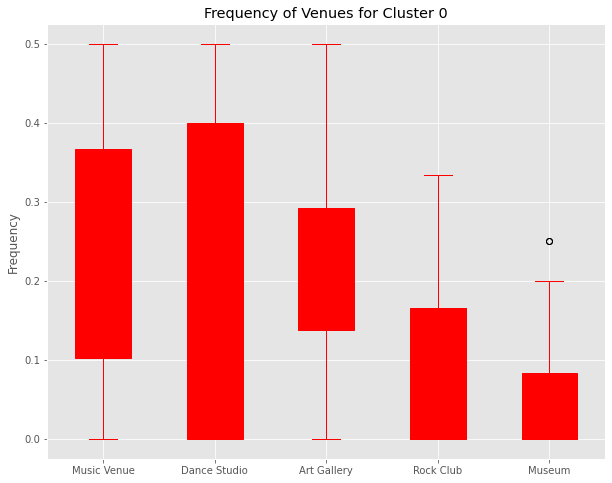

In [50]:
ax = c00_plot.plot(kind='box',
                   figsize=(10,8),
                   color='red',
                   patch_artist=True
                   )
        
ax.set_title('Frequency of Venues for Cluster 0')
ax.set_ylabel('Frequency')
plt.savefig('Cluster 0')


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


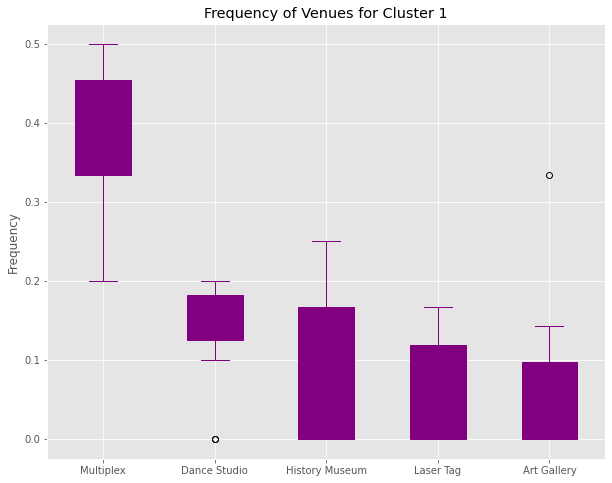

In [51]:
c01=hk_grouped2.loc[hk_grouped2["Cluster Labels"]==1]
c01.loc['Total'] = c01.select_dtypes(pd.np.number).sum()
c01 = c01.sort_values(by ='Total', axis=1, ascending=False)
c01_plot=c01.iloc[:-1, 1:6]

ax = c01_plot.plot(kind='box',
                   figsize=(10,8),
                   color='purple',
                   patch_artist=True
                   )
        
ax.set_title('Frequency of Venues for Cluster 1')
ax.set_ylabel('Frequency')
plt.savefig('Cluster 1')


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


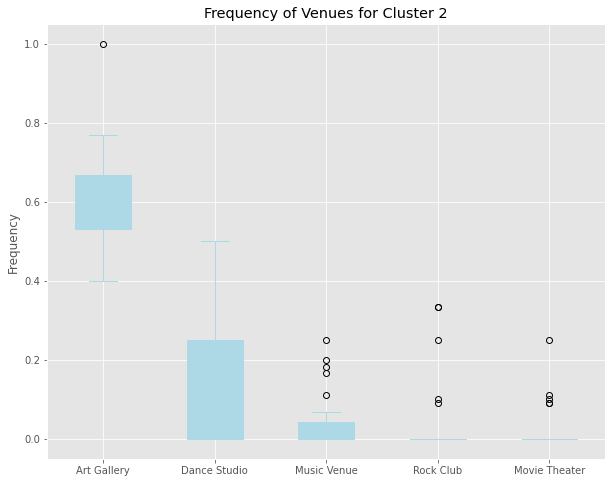

In [52]:
c02=hk_grouped2.loc[hk_grouped2["Cluster Labels"]==2]
c02.loc['Total'] = c02.select_dtypes(pd.np.number).sum()
c02 = c02.sort_values(by ='Total', axis=1, ascending=False)
c02_plot=c02.iloc[:-1, 1:6]

ax = c02_plot.plot(kind='box',
                   figsize=(10,8),
                   color='lightblue',
                   patch_artist=True
                   )
        
ax.set_title('Frequency of Venues for Cluster 2')
ax.set_ylabel('Frequency')
plt.savefig('Cluster 2')

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


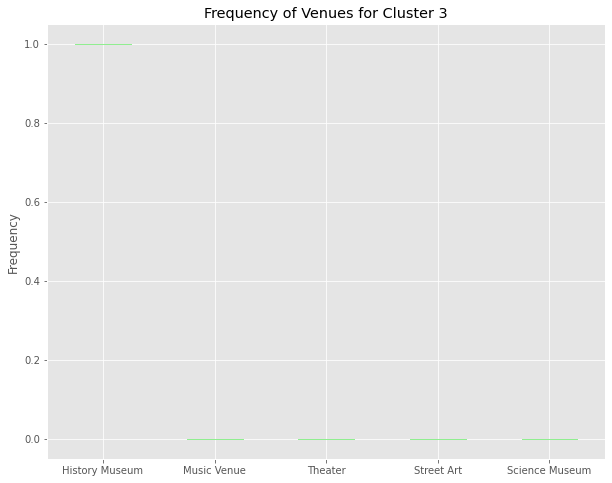

In [53]:
c03=hk_grouped2.loc[hk_grouped2["Cluster Labels"]==3]
c03.loc['Total'] = c03.select_dtypes(pd.np.number).sum()
c03 = c03.sort_values(by ='Total', axis=1, ascending=False)
c03_plot=c03.iloc[:-1, 1:6]

ax = c03_plot.plot(kind='box',
                   figsize=(10,8),
                   color='lightgreen',
                   patch_artist=True
                   )
        
ax.set_title('Frequency of Venues for Cluster 3')
ax.set_ylabel('Frequency')
plt.savefig('Cluster 3')


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


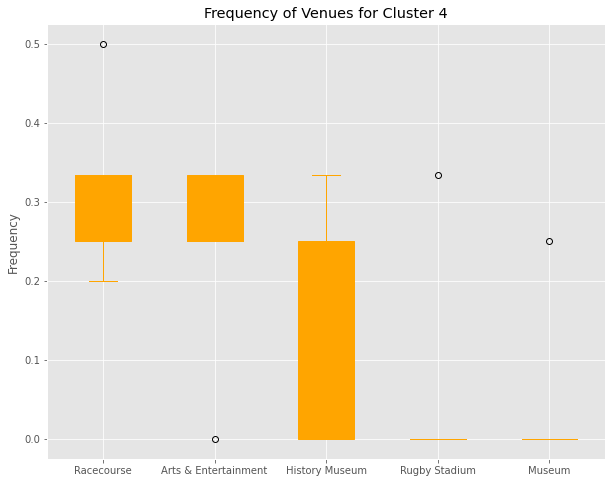

In [54]:
c04=hk_grouped2.loc[hk_grouped2["Cluster Labels"]==4]
c04.loc['Total'] = c04.select_dtypes(pd.np.number).sum()
c04 = c04.sort_values(by ='Total', axis=1, ascending=False)
c04_plot=c04.iloc[:-1, 1:6]

ax = c04_plot.plot(kind='box',
                   figsize=(10,8),
                   color='orange',
                   patch_artist=True
                   )
        
ax.set_title('Frequency of Venues for Cluster 4')
ax.set_ylabel('Frequency')
plt.savefig('Cluster 4')

Text(0, 0.5, 'Frequency')

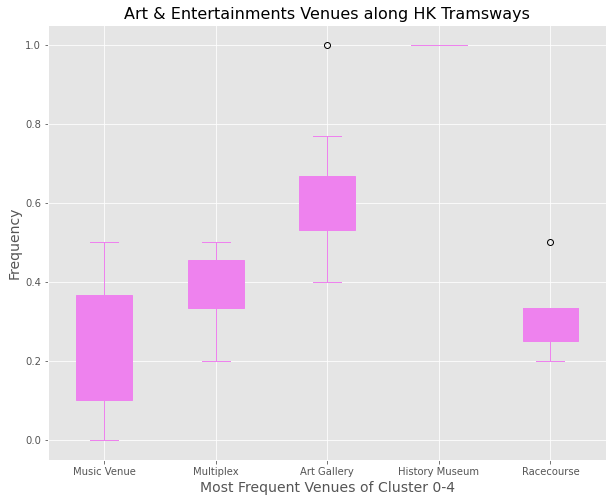

In [55]:
AE_plot=c00_plot.iloc[:,0:1].reset_index(drop=True)
col2=c01_plot.iloc[:,0:1].reset_index(drop=True)
col3=c02_plot.iloc[:,0:1].reset_index(drop=True)
col4=c03_plot.iloc[:,0:1].reset_index(drop=True)
col5=c04_plot.iloc[:,0:1].reset_index(drop=True)

AE_plot=AE_plot.append(col2, ignore_index = True)
AE_plot=AE_plot.append(col3, ignore_index = True)
AE_plot=AE_plot.append(col4, ignore_index = True)
AE_plot=AE_plot.append(col5, ignore_index = True)
AE_plot


ax = AE_plot.plot(kind='box',
                   figsize=(10,8),
                   color='violet',
                   patch_artist=True
                   )
        
ax.set_title('Art & Entertainments Venues along HK Tramsways', fontsize=16)
ax.set_xlabel('Most Frequent Venues of Cluster 0-4', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)


In [56]:
plt.savefig('A&E all clusters')

<Figure size 432x288 with 0 Axes>